In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import time
from datasets import Dataset
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

print(train_data.head(5))
print(len(train_data))

   model                  attack  \
0  human  perplexity_misspelling   
1  human  perplexity_misspelling   
2  human  perplexity_misspelling   
3  human  perplexity_misspelling   
4  human  perplexity_misspelling   

                                          generation  mean_entropy  \
0  Monday evening I did my IM injection in my thi...         527.5   
1  It’s just something I’ve been thinking about r...         603.0   
2  I'm down to about one half of my dose from a w...         642.5   
3  I have very fine but high density 2a/2b hair. ...         530.5   
4  About two weeks ago my dad had a CT scan after...         799.5   

   perplexity   mahalanobis  mc_entropy  
0       2.890  10576.863846     217.625  
1       2.898   8629.160656     136.250  
2       3.590   7739.659480     202.125  
3       2.410  13096.613757     143.125  
4       3.357  15646.024745     139.125  
24012


In [ ]:
models = train_data['model'].unique()
train_dfs = []
test_dfs = []

train_data['label'] = train_data['model'].apply(lambda x: 0 if x == 'human' else 1)
test_data['label'] = test_data['model'].apply(lambda x: 0 if x == 'human' else 1)

In [ ]:
features = ['mean_entropy', 'perplexity', 'mc_entropy', 'mahalanobis']
X_train = train_data[features].values
y_train = train_data['label'].values
X_test = test_data[features].values
y_test = test_data['label'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class AdvancedBinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = AdvancedBinaryClassifier(len(features))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 300
train_losses = []
test_losses = []

In [ ]:
start_time = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
total_time = time.time() - start_time

Epoch 5/300 - Train Loss: 0.3081, Test Loss: 0.2788
Epoch 10/300 - Train Loss: 0.2973, Test Loss: 0.2623
Epoch 15/300 - Train Loss: 0.2891, Test Loss: 0.2679
Epoch 20/300 - Train Loss: 0.2900, Test Loss: 0.2562
Epoch 25/300 - Train Loss: 0.2830, Test Loss: 0.2552
Epoch 30/300 - Train Loss: 0.2837, Test Loss: 0.2587
Epoch 35/300 - Train Loss: 0.2760, Test Loss: 0.2541
Epoch 40/300 - Train Loss: 0.2788, Test Loss: 0.2525
Epoch 45/300 - Train Loss: 0.2787, Test Loss: 0.2601
Epoch 50/300 - Train Loss: 0.2766, Test Loss: 0.2617
Epoch 55/300 - Train Loss: 0.2744, Test Loss: 0.2554
Epoch 60/300 - Train Loss: 0.2743, Test Loss: 0.2533
Epoch 65/300 - Train Loss: 0.2722, Test Loss: 0.2512
Epoch 70/300 - Train Loss: 0.2750, Test Loss: 0.2541
Epoch 75/300 - Train Loss: 0.2715, Test Loss: 0.2505
Epoch 80/300 - Train Loss: 0.2725, Test Loss: 0.2578
Epoch 85/300 - Train Loss: 0.2714, Test Loss: 0.2474
Epoch 90/300 - Train Loss: 0.2676, Test Loss: 0.2488
Epoch 95/300 - Train Loss: 0.2683, Test Loss: 0

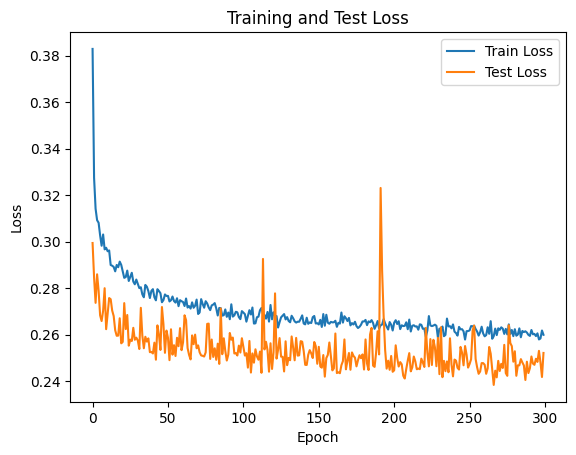

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

classifier_metrics = {}
classifier_metrics["Accuracy"] = accuracy
classifier_metrics["Precision"] = precision
classifier_metrics["Recall"] = recall
classifier_metrics["ROC-AUC"] = auc
classifier_metrics["Train Time"] = total_time

In [ ]:
model = LogisticRegression()

start_time = time.time()
model.fit(X_train, y_train)
total_time = time.time() - start_time

probabilities = model.predict_proba(X_test)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

regression_metrics = {}
regression_metrics["Accuracy"] = accuracy
regression_metrics["Precision"] = precision
regression_metrics["Recall"] = recall
regression_metrics["ROC-AUC"] = auc
regression_metrics["Train Time"] = total_time

In [ ]:
model = RandomForestClassifier(n_estimators=300, max_depth = 10)

start_time = time.time()
model.fit(X_train, y_train)
total_time = time.time() - start_time

probabilities = model.predict_proba(X_test)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

forest_metrics = {}
forest_metrics["Accuracy"] = accuracy
forest_metrics["Precision"] = precision
forest_metrics["Recall"] = recall
forest_metrics["ROC-AUC"] = auc
forest_metrics["Train Time"] = total_time

In [ ]:
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

X_train = train_data[['generation', 'label']]
X_test = test_data[['generation', 'label']]

train_dataset = Dataset.from_pandas(X_train)
test_dataset = Dataset.from_pandas(X_test)

def tokenize_function(examples):
    return tokenizer(examples["generation"], padding="max_length", truncation=True, max_length=512)

tokenized_train = train_dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1
)
training_args.report_to = []


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train
)
start_time = time.time()
trainer.train()
total_time = time.time() - start_time

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/24012 [00:00<?, ? examples/s]

Step,Training Loss
500,0.636600
1000,0.279400
1500,0.211400
2000,0.135700
2500,0.135400
3000,0.108600


In [ ]:
def classify_text(text, device = "cuda"):
    model.to(device)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

true_labels = []
predicted_labels = []

for i, row in test_data.iterrows():
    text = row["generation"]
    true_label = row["label"]
    predicted_label = classify_text(text)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
auc = roc_auc_score(true_labels, predicted_labels)

BERT_classifier_metrics = {}
BERT_classifier_metrics["Accuracy"] = accuracy
BERT_classifier_metrics["Precision"] = precision
BERT_classifier_metrics["Recall"] = recall
BERT_classifier_metrics["ROC-AUC"] = auc
BERT_classifier_metrics["Train Time"] = total_time

In [ ]:
metrics = {
    'BERT_Classifier': BERT_classifier_metrics,
    'Neural_Classifier_with_uncertainty': classifier_metrics,
    'Logistic_Regression_with_uncertainty': regression_metrics,
    'Random_forest_with_uncertainty': forest_metrics
}

df = pd.DataFrame(metrics).T.round(4)
print(df)

                                      Accuracy  Precision  Recall  ROC-AUC  \
BERT_Classifier                         0.9538     0.9896  0.9156   0.9532   
Neural_Classifier_with_uncertainty      0.8987     0.9557  0.8326   0.8977   
Logistic_Regression_with_uncertainty    0.7271     0.7651  0.6426   0.7258   
Random_forest_with_uncertainty          0.8992     0.9262  0.8640   0.8987   

                                      Train Time  
BERT_Classifier                        2362.1725  
Neural_Classifier_with_uncertainty      378.1838  
Logistic_Regression_with_uncertainty      0.0350  
Random_forest_with_uncertainty           10.7419  
